In [ ]:
import pandas as pd
import re
from pathlib import Path

def clean_text(text):
    """Normalize multi-line commit messages and remove quotes."""
    if pd.isna(text):
        return ""
    return " ".join(str(text).strip('"').split())

def preprocess_text(text):
    """Lowercase, remove punctuation, and tokenize into words."""
    if pd.isna(text):
        return []
    text = text.lower()
    return re.findall(r"[a-zA-Z_]+", text)

def extract_diff_keywords(diff_text):
    """Extract meaningful keywords (function names, variables) from diff."""
    if pd.isna(diff_text):
        return []
    diff_text = re.sub(r"@@.*?@@", " ", diff_text)
    diff_text = diff_text.replace("+", " ").replace("-", " ")
    keywords = re.findall(r"[a-zA-Z_][a-zA-Z_0-9]*", diff_text)
    blacklist = {"if", "else", "for", "while", "return", "int", "float",
                 "void", "import", "from", "class", "def"}
    return [kw.lower() for kw in keywords if kw.lower() not in blacklist]

def score_message(message_words, reference_words, diff_keywords, filename):
    """
    Scoring a commit message using weighted rules:
    - +1: common important words between message and reference
    - +1: same starting word as reference
    - +2: diff keywords appear in message
    - +1: filename is mentioned
    """
    score = 0

    # Common words
    common_with_ref = set(message_words).intersection(set(reference_words))
    if len(common_with_ref) >= 1:
        score += 1

    # Starting word same as reference
    if message_words and reference_words and message_words[0] == reference_words[0]:
        score += 1

    # Diff keyword overlap → +2
    if any(kw in message_words for kw in diff_keywords):
        score += 2

    # Filename mentioned → +1
    base_filename = Path(filename).stem.lower() if filename else ""
    if base_filename and base_filename in message_words:
        score += 1

    return score

def is_precise(score, threshold):
    """Return True if commit message is precise enough."""
    return score >= threshold


#

# Load CSV
df = pd.read_csv("bug_fix_commit_diffs_with_llm.csv")

# Clean commit messages and LLM inference
df["Commit Message"] = df["Commit Message"].apply(clean_text)
df["LLM Inference (fix type)"] = df["LLM Inference (fix type)"].apply(clean_text)

# Prepare columns
df["Dev_Score"] = 0
df["LLM_Score"] = 0
df["Rectifier_Score"] = 0
df["Dev_Precise"] = False
df["LLM_Precise"] = False
df["Rectifier_Precise"] = False
df["Rectified Message"] = ""

for idx, row in df.iterrows():
    commit_msg = row["Commit Message"]
    llm_msg = row["LLM Inference (fix type)"]
    diff_text = row["Diff"]
    filename = row["Filename"]

    # Preprocess texts
    msg_words = preprocess_text(commit_msg)
    llm_words = preprocess_text(llm_msg)
    diff_keywords = extract_diff_keywords(diff_text)

    # Developer and LLM scores
    dev_score = score_message(msg_words, llm_words, diff_keywords, filename)
    llm_score = score_message(llm_words, msg_words, diff_keywords, filename)

    df.at[idx, "Dev_Score"] = dev_score
    df.at[idx, "LLM_Score"] = llm_score
    df.at[idx, "Dev_Precise"] = is_precise(dev_score,3)
    df.at[idx, "LLM_Precise"] = is_precise(llm_score,3)

    # Rectified message selection
    if df.at[idx, "Dev_Precise"] and df.at[idx, "LLM_Precise"]:
        if(dev_score>=llm_score):
            rectified_msg = commit_msg
        else:
            rectified_msg = llm_msg
    elif df.at[idx, "LLM_Precise"]:
        rectified_msg = llm_msg
    elif df.at[idx, "Dev_Precise"]:
        rectified_msg = commit_msg
    else:
        rectified_msg = f"{llm_msg}\n\n{commit_msg}"

    # Save rectified message
    df.at[idx, "Rectified Message"] = rectified_msg

    # Rectifier score & precision
    rectified_words = preprocess_text(rectified_msg)
    rect_score = score_message(rectified_words, rectified_words, diff_keywords, filename)
    df.at[idx, "Rectifier_Score"] = rect_score
    df.at[idx, "Rectifier_Precise"] = is_precise(rect_score,4)


# ---------------------
# Hit Rate Calculation
# ---------------------
total_commits = len(df)
dev_hit_rate = df["Dev_Precise"].mean() * 100
llm_hit_rate = df["LLM_Precise"].mean() * 100
rectifier_hit_rate = df["Rectifier_Precise"].mean() * 100

print("\n===== HIT RATES =====")
print(f"Developer Hit Rate: {dev_hit_rate:.2f}%")
print(f"LLM Hit Rate:       {llm_hit_rate:.2f}%")
print(f"Rectifier Hit Rate: {rectifier_hit_rate:.2f}%")

# Save CSV with rectifier precision
df.to_csv("bug_fix_commits_with_rectified.csv", index=False)
print("\nResults saved to 'bug_fix_commits_with_rectified.csv'")


===== HIT RATES =====
Developer Hit Rate: 47.69%
LLM Hit Rate:       37.84%
Rectifier Hit Rate: 81.27%

Results saved to 'bug_fix_commits_with_rectified.csv'


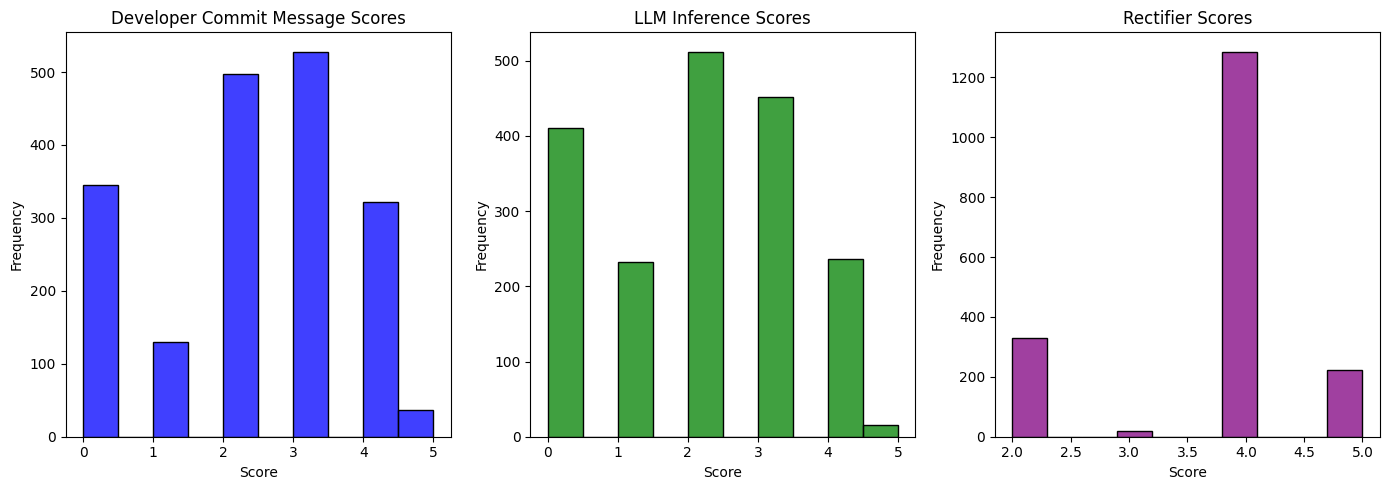

In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is called df and has these columns:
# "Dev_Score", "LLM_Score", "Rectifier_Score"
# Replace with actual column names if different.
df = pd.read_csv("bug_fix_commits_with_rectified.csv")
plt.figure(figsize=(14, 5))

# Plot histogram for Developer scores
plt.subplot(1, 3, 1)
sns.histplot(df["Dev_Score"], bins=10, color="blue")
plt.title("Developer Commit Message Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")

# Plot histogram for LLM scores
plt.subplot(1, 3, 2)
sns.histplot(df["LLM_Score"], bins=10,color="green")
plt.title("LLM Inference Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")

# Plot histogram for Rectifier scores
plt.subplot(1, 3, 3)
sns.histplot(df["Rectifier_Score"], bins=10, color="purple")
plt.title("Rectifier Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
import re
from pathlib import Path
import pandas as pd
from collections import Counter, defaultdict

ACTION_VERBS = {
    "fix","add","remove","delete","update","rename","refactor","revert","handle",
    "guard","validate","optimize","restore","document","deprecate","restrict",
    "escape","sanitize","fallback","retry","bypass","patch","correct","resolve"
}

WHY_KEYWORDS = {
    # symptoms / reasons
    "bug","crash","hang","freeze","deadlock","race","leak","overflow","underflow",
    "timeout","regression","panic","segfault","exception","error","failure","incorrect",
    "wrong","null","none","npe","oob","index","bounds","typo","mismatch","broken",
    "unstable","flaky","degrade","corrupt","security","vulnerability","dos","infinite","loop"
}

# Phrases indicating condition/why
WHY_PHRASE_PAT = re.compile(r"\b(when|if|on|during|because|due to|caused by)\b", re.I)
ISSUE_REF_PAT  = re.compile(r"\b(?:fixe?s?|close?s?)\s*(?:#\d+|\bissue\b|\bpr\b|\bgh-\d+\b)", re.I)
ID_PAT         = re.compile(r"[A-Za-z_][A-Za-z0-9_]*")
FUNC_DEF_PAT   = re.compile(r"^\s*(?:def|function)\s+([A-Za-z_][A-Za-z0-9_]*)", re.I | re.M)
CLASS_DEF_PAT  = re.compile(r"^\s*(?:class)\s+([A-Za-z_][A-Za-z0-9_]*)", re.I | re.M)

STOPWORDS = {
    "the","a","an","to","in","of","and","or","for","by","with","from","on","at","as",
    "is","are","be","was","were","this","that","these","those","it","its","into","via",
    "adds","added","fixes","fixed","removes","removed","updates","updated","renames","renamed"
}

def norm_text(s: str) -> str:
    if pd.isna(s): return ""
    return " ".join(str(s).strip().split())

def words(s: str):
    return [w.lower() for w in re.findall(r"[A-Za-z_][A-Za-z0-9_]*", s)]

def has_action_verb(msg_words) -> bool:
    # look for an action verb near the beginning (subject line)
    for w in msg_words[:12]:
        if w in ACTION_VERBS:
            return True
    return any(w in ACTION_VERBS for w in msg_words)

def has_why(msg: str, msg_words) -> bool:
    if any(w in WHY_KEYWORDS for w in msg_words):
        return True
    if WHY_PHRASE_PAT.search(msg):
        return True
    if ISSUE_REF_PAT.search(msg):
        return True
    return False

def top_k(counter: Counter, k=8):
    return [t for t,_ in counter.most_common(k)]

def extract_where_entities(diff_text: str, filename: str):
    """
    Pull 'where' entities from the diff:
      - base filename (without ext)
      - class names, function names
      - frequently-changed identifiers on +/- lines
    """
    ents = Counter()
    if filename:
        base = Path(filename).stem.lower()
        if base:
            ents[base] += 4  # strong prior: file base

    if not diff_text or pd.isna(diff_text):
        return set(ents.keys())

    # strip diff markers @@ ... @@ and keep changed lines context
    core = re.sub(r"@@.*?@@", " ", diff_text, flags=re.S)

    # collect identifiers from added/removed/context lines
    # boost + / - lines slightly
    for line in core.splitlines():
        line_l = line.strip().lower()
        boost = 2 if line_l.startswith("+") or line_l.startswith("-") else 1

        # defs/classes get extra weight
        for m in FUNC_DEF_PAT.finditer(line):
            ents[m.group(1).lower()] += 3*boost
        for m in CLASS_DEF_PAT.finditer(line):
            ents[m.group(1).lower()] += 3*boost

        for tok in ID_PAT.findall(line):
            t = tok.lower()
            if t in STOPWORDS: 
                continue
            # ignore common keywords
            if t in {"import","from","class","def","return","if","else","for","while","try","except","var","let","const"}:
                continue
            ents[t] += boost

    # keep top-k as salient "where" entities
    return set(top_k(ents, k=12))

def covers_where(msg_words, where_entities) -> bool:
    return any(w in where_entities for w in msg_words)

def www_score(msg: str, diff_text: str, filename: str):
    """Compute WWW: What/Where/Why booleans and total."""
    msg_n = norm_text(msg)
    mw = words(msg_n)

    where_ents = extract_where_entities(diff_text, filename)

    W_hat = has_action_verb(mw)                       # What
    Whr   = covers_where(mw, where_ents)              # Where
    Why   = has_why(msg_n, mw)                        # Why

    total = int(W_hat) + int(Whr) + int(Why)
    expl = {
        "What": W_hat,
        "Where_entities_hit": sorted(set(mw).intersection(where_ents)) if Whr else [],
        "Why": Why
    }
    return total, expl

# ---------------------
# Load 
# ---------------------
in_csv  = "bug_fix_commit_diffs_with_llm.csv"  
out_csv = "bug_fix_commits_scored.csv"

df = pd.read_csv(in_csv)

# Normalize relevant columns
for col in ["Commit Message","LLM Inference (fix type)","Rectified Message","Diff","Filename"]:
    if col in df.columns:
        df[col] = df[col].apply(norm_text)
    else:
        df[col] = ""

# ---------------------
#   ( prefer precise; if both precise, pick higher WWW, then shorter;
#    if neither precise, combine LLM + Dev)
# ---------------------
def choose_rectified(dev_msg, llm_msg, diff_text, filename):
    dev_www, _ = www_score(dev_msg, diff_text, filename)
    llm_www, _ = www_score(llm_msg, diff_text, filename)

    if dev_www >= 2 and llm_www < 2:
        return dev_msg
    if llm_www >= 2 and dev_www < 2:
        return llm_msg
    if dev_www >= 2 and llm_www >= 2:
        # tie-break by WWW total, then brevity
        if llm_www > dev_www:
            return llm_msg
        if dev_www > llm_www:
            return dev_msg
        # equal WWW: pick the one that mentions more 'where' entities, else shorter
        dev_ents = len(set(words(dev_msg)).intersection(extract_where_entities(diff_text, filename)))
        llm_ents = len(set(words(llm_msg)).intersection(extract_where_entities(diff_text, filename)))
        if llm_ents > dev_ents:
            return llm_msg
        if dev_ents > llm_ents:
            return dev_msg
        return llm_msg if len(llm_msg) < len(dev_msg) else dev_msg

    # neither precise: synthesize or combine
    if llm_msg and dev_msg:
        return f"{llm_msg}\n\n{dev_msg}"
    return llm_msg or dev_msg

# Fill rectified where missing/blank
if "Rectified Message" not in df.columns:
    df["Rectified Message"] = ""
df["Rectified Message"] = df.apply(
    lambda r: (r["Rectified Message"] if r["Rectified Message"] 
               else choose_rectified(r["Commit Message"], r["LLM Inference (fix type)"], r["Diff"], r["Filename"])),
    axis=1,
)

# ---------------------
# Score all three: Dev / LLM / Rectified
# ---------------------
cols = defaultdict(list)

for _, r in df.iterrows():
    dev_msg = r["Commit Message"]
    llm_msg = r["LLM Inference (fix type)"]
    rec_msg = r["Rectified Message"]
    diff    = r["Diff"]
    fname   = r["Filename"]

    dev_www, dev_expl = www_score(dev_msg, diff, fname)
    llm_www, llm_expl = www_score(llm_msg, diff, fname)
    rec_www, rec_expl = www_score(rec_msg, diff, fname)

    # store
    cols["Dev_WWW"].append(dev_www)
    cols["Dev_Precise_Lenient(>=2)"].append(dev_www >= 2)
    cols["Dev_Precise_Strict(==3)"].append(dev_www == 3)
    cols["Dev_Explain"].append(dev_expl)

    cols["LLM_WWW"].append(llm_www)
    cols["LLM_Precise_Lenient(>=2)"].append(llm_www >= 2)
    cols["LLM_Precise_Strict(==3)"].append(llm_www == 3)
    cols["LLM_Explain"].append(llm_expl)

    cols["Rect_WWW"].append(rec_www)
    cols["Rect_Precise_Lenient(>=2)"].append(rec_www >= 2)
    cols["Rect_Precise_Strict(==3)"].append(rec_www == 3)
    cols["Rect_Explain"].append(rec_expl)

# Attach to DF
for k,v in cols.items():
    df[k] = v

# ---------------------
# Hit rates (RQ1–RQ3)
# ---------------------
def pct(x): 
    return 100.0 * (sum(x) / len(x) if len(x) else 0.0)

rq1_len = pct(df["Dev_Precise_Lenient(>=2)"])
rq2_len = pct(df["LLM_Precise_Lenient(>=2)"])
rq3_len = pct(df["Rect_Precise_Lenient(>=2)"])

rq1_str = pct(df["Dev_Precise_Strict(==3)"])
rq2_str = pct(df["LLM_Precise_Strict(==3)"])
rq3_str = pct(df["Rect_Precise_Strict(==3)"])

print("\n===== HIT RATES (WWW rubric) =====")
print(f"Lenient (WWW ≥ 2):  Dev={rq1_len:.2f}%  LLM={rq2_len:.2f}%  Rectifier={rq3_len:.2f}%")
print(f"Strict  (WWW = 3):  Dev={rq1_str:.2f}%  LLM={rq2_str:.2f}%  Rectifier={rq3_str:.2f}%")

# ---------------------
# Save enriched CSV
# ---------------------
df.to_csv(out_csv, index=False)
print(f"\nSaved scored results to '{out_csv}'")



===== HIT RATES (WWW rubric) =====
Lenient (WWW ≥ 2):  Dev=63.56%  LLM=35.68%  Rectifier=79.55%
Strict  (WWW = 3):  Dev=26.43%  LLM=1.67%  Rectifier=27.72%

Saved scored results to 'bug_fix_commits_scored.csv'


In [13]:
df=pd.read_csv("bug_fix_commits_scored.csv")
df.columns

Index(['Commit Hash', 'Commit Message', 'Filename',
       'Source code(changed lines before)', 'Souce code(changed lines after)',
       'Diff', 'LLM Inference (fix type)', 'Rectified Message', 'Dev_WWW',
       'Dev_Precise_Lenient(>=2)', 'Dev_Precise_Strict(==3)', 'Dev_Explain',
       'LLM_WWW', 'LLM_Precise_Lenient(>=2)', 'LLM_Precise_Strict(==3)',
       'LLM_Explain', 'Rect_WWW', 'Rect_Precise_Lenient(>=2)',
       'Rect_Precise_Strict(==3)', 'Rect_Explain'],
      dtype='object')

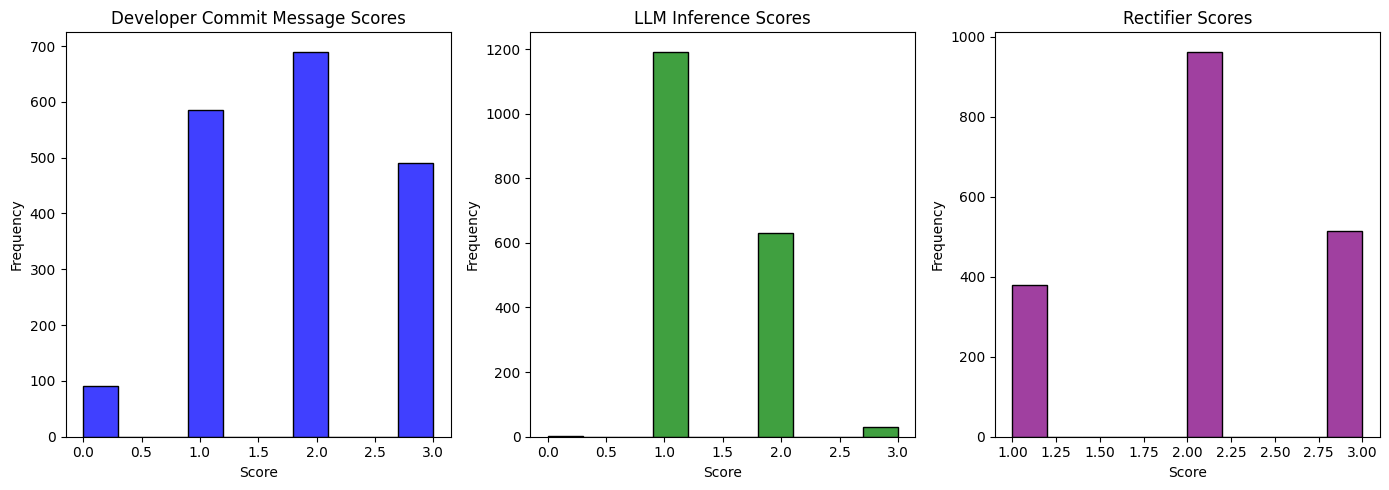

In [14]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is called df and has these columns:
# "Dev_Score", "LLM_Score", "Rectifier_Score"
# Replace with actual column names if different.
df = pd.read_csv("bug_fix_commits_scored.csv")
plt.figure(figsize=(14, 5))

# Plot histogram for Developer scores
plt.subplot(1, 3, 1)
sns.histplot(df["Dev_WWW"], bins=10, color="blue")
plt.title("Developer Commit Message Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")

# Plot histogram for LLM scores
plt.subplot(1, 3, 2)
sns.histplot(df["LLM_WWW"], bins=10,color="green")
plt.title("LLM Inference Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")

# Plot histogram for Rectifier scores
plt.subplot(1, 3, 3)
sns.histplot(df["Rect_WWW"], bins=10, color="purple")
plt.title("Rectifier Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
df=pd.read_csv("bug_fix_commits_with_rectified.csv")
df.columns

Index(['Commit Hash', 'Commit Message', 'Filename',
       'Source code(changed lines before)', 'Souce code(changed lines after)',
       'Diff', 'LLM Inference (fix type)', 'Rectified Message', 'Dev_Score',
       'LLM_Score', 'Rectifier_Score', 'Dev_Precise', 'LLM_Precise',
       'Rectifier_Precise'],
      dtype='object')

In [7]:
df = pd.read_csv("bug_fix_commits_py.csv")
df.columns

Index(['Hash', 'Message', 'Parent Hashes', 'Is a Merge Commit?',
       'List of Modified Files'],
      dtype='object')

In [13]:
import csv
import sys
from pydriller import Repository

# Increase CSV field size limit to handle very large code blobs
csv.field_size_limit(sys.maxsize)

# GitHub repository to analyze
REPO_URL = "https://github.com/comfyanonymous/ComfyUI"

# Input datasets
commits_csv = "bug_fix_commits_py.csv"                 # Contains commit hashes
rectified_csv = "bug_fix_commits_with_rectified.csv"   # Contains LLM inference + rectified messages
output_csv = "bug_fix_commits_with_full_code.csv"

# Load both LLM inference and rectified messages from rectified_csv
commit_extra_info = {}  # {commit_hash: {"llm": ..., "rectified": ...}}
with open(rectified_csv, newline='', encoding='utf-8') as rect_file:
    reader = csv.DictReader(rect_file)
    for row in reader:
        commit_extra_info[row['Commit Hash']] = {
            "llm": row.get('LLM Inference (fix type)', ''),
            "rectified": row.get('Rectified Message', '')
        }

# Read bug-fixing commit hashes from commits_csv
commit_hashes = []
with open(commits_csv, newline='', encoding='utf-8') as infile:
    reader = csv.DictReader(infile)
    for row in reader:
        commit_hashes.append(row['Hash'])

# Prepare output CSV
with open(output_csv, 'w', newline='', encoding='utf-8') as outfile:
    writer = csv.writer(outfile)
    writer.writerow([
        'Commit Hash',
        'Commit Message',
        'LLM Inference (fix type)',
        'Rectified Message',
        'Filename',
        'Source Code (before)',
        'Source Code (after)',
        'Diff'
    ])

    print(f"Processing {len(commit_hashes)} commits...")

    for commit in Repository(REPO_URL, only_commits=commit_hashes).traverse_commits():
        for mod in commit.modified_files:
            before_code = mod.source_code_before if mod.source_code_before else ""
            after_code = mod.source_code if mod.source_code else ""
            diff_text = mod.diff or ""

            # Safely get both LLM inference and rectified message
            llm_inference = commit_extra_info.get(commit.hash, {}).get("llm", "")
            rectified_msg = commit_extra_info.get(commit.hash, {}).get("rectified", "")

            writer.writerow([
                commit.hash,
                commit.msg,
                llm_inference,
                rectified_msg,
                mod.new_path or mod.old_path,
                before_code,
                after_code,
                diff_text
            ])

print("Done! Output written to", output_csv)


Processing 828 commits...
Done! Output written to bug_fix_commits_with_full_code.csv


In [14]:
df=pd.read_csv("bug_fix_commits_with_full_code.csv")
df.columns

Index(['Commit Hash', 'Commit Message', 'LLM Inference (fix type)',
       'Rectified Message', 'Filename', 'Source Code (before)',
       'Source Code (after)', 'Diff'],
      dtype='object')

## Lab-3 part

In [ ]:
import pandas as pd
from collections import Counter
import os

csv_path = "bug_fix_commits_with_full_code.csv"

df = pd.read_csv(csv_path)

# Unique commits & unique files changed ---
unique_commits = df["Commit Hash"].nunique()
unique_files = df["Filename"].nunique()

# Average number of modified files per commit ---
files_per_commit = df.groupby("Commit Hash")["Filename"].nunique()
avg_files_per_commit = files_per_commit.mean()

# Distribution of fix types ---
fix_type_distribution = df["LLM Inference (fix type)"].value_counts()

# Most frequently modified filenames ---
most_modified_files = df["Filename"].value_counts().head(10)

# Most frequently modified file extensions ---
df["Extension"] = df["Filename"].apply(lambda x: os.path.splitext(str(x))[1])
most_modified_extensions = df["Extension"].value_counts().head(10)

print("=== Descriptive Statistics ===")
print(f"Unique commits: {unique_commits}")
print(f"Unique files changed: {unique_files}")
print(f"Average number of modified files per commit: {avg_files_per_commit:.2f}\n")

print("=== Distribution of Fix Types ===")
print(fix_type_distribution, "\n")

print("=== Most Frequently Modified Files ===")
print(most_modified_files, "\n")

print("=== Most Frequently Modified File Extensions ===")
print(most_modified_extensions)

# --- Optional: Save stats to CSVs ---
fix_type_distribution.to_csv("fix_type_distribution.csv")
most_modified_files.to_csv("most_modified_files.csv")
most_modified_extensions.to_csv("most_modified_extensions.csv")


=== Descriptive Statistics ===
Unique commits: 828
Unique files changed: 502
Average number of modified files per commit: 2.24

=== Distribution of Fix Types ===
LLM Inference (fix type)
add missing newline                             97
add missing import                              70
add test for async validation                   36
add missing documentation                       35
add missing docstrings                          35
                                                ..
fix basicscheduler                               1
add test for send_socket_catch_exception         1
add model_keys to modelpatcher                   1
allow fp16 accumulation in the gpu               1
add support_fp8_ops to torch_version_numeric     1
Name: count, Length: 667, dtype: int64 

=== Most Frequently Modified Files ===
Filename
nodes.py                          112
comfy/model_management.py          81
comfy/sd.py                        71
comfy/model_patcher.py             59
server.py  

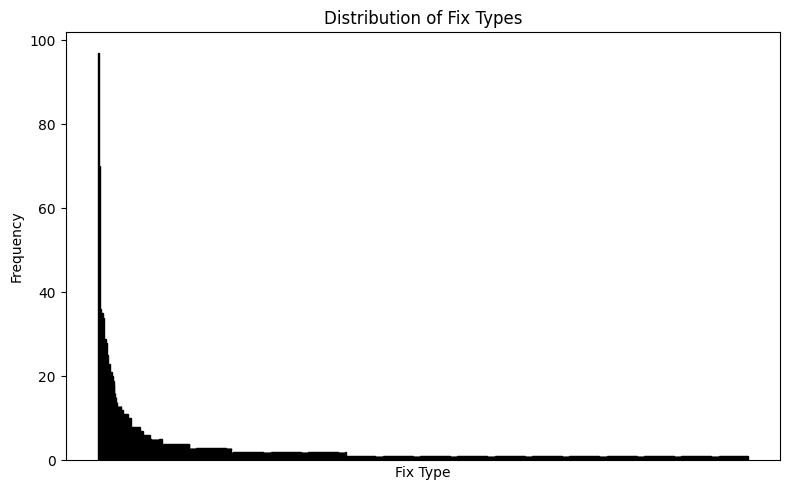

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(df["LLM Inference (fix type)"], df["count"], color="skyblue", edgecolor="black")
plt.xlabel("Fix Type")
plt.ylabel("Frequency")
plt.title("Distribution of Fix Types")

# Remove all x-axis labels
plt.xticks([])
plt.tight_layout()
plt.show()


In [16]:
!pip install radon


Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [radon]


In [ ]:
import pandas as pd
from radon.complexity import cc_visit
from radon.metrics import mi_visit
from radon.raw import analyze

# Load dataset
df = pd.read_csv("bug_fix_commits_with_full_code.csv")

# Functions to compute MI, CC, and LOC safely
def compute_metrics(code):
    if pd.isna(code) or not isinstance(code, str) or code.strip() == "":
        return None, None, None  # MI, CC, LOC

    try:
        # Maintainability Index
        mi = mi_visit(code, True)

        # Cyclomatic Complexity: average CC of all blocks
        cc_blocks = cc_visit(code)
        cc = sum(block.complexity for block in cc_blocks) / len(cc_blocks) if cc_blocks else 0

        # Lines of Code
        raw_metrics = analyze(code)
        loc = raw_metrics.loc  # lines of code
        return mi, cc, loc

    except Exception:
        return None, None, None

# Compute metrics for "before" and "after" code
df[['MI_Before', 'CC_Before', 'LOC_Before']] = df['Source Code (before)'].apply(
    lambda code: pd.Series(compute_metrics(code))
)
df[['MI_After', 'CC_After', 'LOC_After']] = df['Source Code (after)'].apply(
    lambda code: pd.Series(compute_metrics(code))
)

# Compute changes
df['MI_Change'] = df['MI_After'] - df['MI_Before']
df['CC_Change'] = df['CC_After'] - df['CC_Before']
df['LOC_Change'] = df['LOC_After'] - df['LOC_Before']

# Save to CSV
df.to_csv("bug_fix_commits_with_metrics.csv", index=False)
print("Metrics computed and saved to bug_fix_commits_with_metrics.csv")


In [18]:
df=pd.read_csv("bug_fix_commits_with_metrics.csv")
df

,Commit Hash,Commit Message,LLM Inference (fix type),Rectified Message,Filename,Source Code (before),Source Code (after),Diff,MI_Before,CC_Before,LOC_Before,MI_After,CC_After,LOC_After,MI_Change,CC_Change,LOC_Change
0,9baa48cb33d72ce4946a522f1fa0b4d30f979e63,Add IS_CHANGED method to nodes to check if nod...,add missing class to loadimage,Add IS_CHANGED method to nodes to check if nod...,main.py,import os\nimport sys\nimport copy\nimport jso...,import os\nimport sys\nimport copy\nimport jso...,"@@ -10,27 +10,8 @@ import torch\n \n import no...",18.450872,6.466667,314.0,16.796487,6.437500,331.0,-1.654386,-0.029167,17.0
1,9baa48cb33d72ce4946a522f1fa0b4d30f979e63,Add IS_CHANGED method to nodes to check if nod...,add missing class to loadimage,Add IS_CHANGED method to nodes to check if nod...,nodes.py,import torch\n\nimport os\nimport sys\nimport ...,import torch\n\nimport os\nimport sys\nimport ...,"@@ -3,6 +3,7 @@ import torch\n import os\n imp...",33.601288,1.666667,244.0,32.925277,1.648649,253.0,-0.676012,-0.018018,9.0
2,c1eac7bab24f679b866acdf17f91e1bda590f9e4,Add filename_prefix to SaveImage node.,add kSampler example,Add filename_prefix to SaveImage node.,nodes.py,import torch\n\nimport os\nimport sys\nimport ...,import torch\n\nimport os\nimport sys\nimport ...,"@@ -180,15 +180,12 @@ class KSampler:\n class ...",32.925277,1.648649,253.0,31.498435,1.675676,262.0,-1.426841,0.027027,9.0
3,b9308407b22bc922bf8def9f7c260c70f9f90728,Make webui return correct mimetypes for css an...,add missing header,add missing header\n\nMake webui return correc...,main.py,import os\nimport sys\nimport copy\nimport jso...,import os\nimport sys\nimport copy\nimport jso...,"@@ -294,7 +294,12 @@ class PromptServer(BaseHT...",14.738526,6.529412,358.0,14.291801,6.647059,363.0,-0.446726,0.117647,5.0
4,051f472e8f851523a898cd183b5783a372c3c1c3,Fix sub quadratic attention for SD2 and make i...,add missing autocast support to train_attention,add missing autocast support to train_attentio...,comfy/ldm/modules/attention.py,from inspect import isfunction\nimport math\ni...,from inspect import isfunction\nimport math\ni...,"@@ -175,13 +175,11 @@ class CrossAttentionBirc...",30.605555,2.777778,533.0,28.379468,2.810811,539.0,-2.226087,0.033033,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,deebee4ff6fd1b2713683d22e5e2e07170daa867,Update default parameters for Moonvalley video...,add v2v validation to comfy_api_nodes,Update default parameters for Moonvalley video...,comfy_api_nodes/nodes_moonvalley.py,"import logging\nfrom typing import Any, Callab...","import logging\nfrom typing import Any, Callab...","@@ -1,6 +1,5 @@\n import logging\n from typing...",35.579796,2.617647,743.0,34.375197,2.705882,797.0,-1.204598,0.088235,54.0
1854,f0d5d0111f1f78bc8ce5d1f3968f19e40cd2ce7b,Avoid torch compile graphbreak for older pytor...,add a warning for pytorch < 2.9,Avoid torch compile graphbreak for older pytor...,comfy/ops.py,"""""""\n This file is part of ComfyUI.\n Co...","""""""\n This file is part of ComfyUI.\n Co...","@@ -41,9 +41,11 @@ try:\n \n SDPA_BACK...",30.108035,3.769231,464.0,30.764953,3.769231,466.0,0.656918,0.000000,2.0
1855,4e5c230f6a957962961794c07f02be748076c771,Fix last commit not working on older pytorch. ...,fix the sdpa backend priority,Fix last commit not working on older pytorch. ...,comfy/ops.py,"""""""\n This file is part of ComfyUI.\n Co...","""""""\n This file is part of ComfyUI.\n Co...","@@ -32,20 +32,21 @@ def scaled_dot_product_att...",30.764953,3.769231,466.0,29.746925,3.769231,467.0,-1.018028,0.000000,1.0
1856,027c63f63a7f5f380a4df1057c548410b0a87606,fix(OpenAIGPTImage1): set correct MIME type fo...,add docs for the image generation,fix(OpenAIGPTImage1): set correct MIME type fo...,comfy_api_nodes/nodes_openai.py,"import io\nfrom typing import TypedDict, Optio...","import io\nfrom typing import TypedDict, Optio...","@@ -464,8 +464,6 @@ class OpenAIGPTImage1(Comf...",28.394776,2.292683,1008.0,28.647318,2.292

In [ ]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

df = pd.read_csv("bug_fix_commits_with_full_code.csv")

# -----------------------------
# Load CodeBERT model & tokenizer
# -----------------------------
MODEL_NAME = "microsoft/codebert-base"
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaModel.from_pretrained(MODEL_NAME)
model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -----------------------------
# Helper: Get CodeBERT Embeddings
# -----------------------------
def get_embedding(code):
    inputs = tokenizer(code, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # Use CLS token embedding
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

# -----------------------------
# Helper: Compute BLEU Score
# -----------------------------
smooth_fn = SmoothingFunction().method1

def compute_bleu(before, after):
    ref_tokens = before.split()
    hyp_tokens = after.split()
    return sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smooth_fn)

# -----------------------------
# Compute Metrics for Each Row
# -----------------------------
semantic_similarities = []
token_similarities = []

for _, row in df.iterrows():
    before_code = str(row["Source Code (before)"])
    after_code = str(row["Source Code (after)"])

    # Semantic similarity via CodeBERT
    try:
        emb_before = get_embedding(before_code)
        emb_after = get_embedding(after_code)
        sem_sim = cosine_similarity(emb_before, emb_after)[0][0]
    except Exception:
        sem_sim = None

    # Token similarity via BLEU
    try:
        bleu_score = compute_bleu(before_code, after_code)
    except Exception:
        bleu_score = None

    semantic_similarities.append(sem_sim)
    token_similarities.append(bleu_score)

# -----------------------------
# Add Results to DataFrame
# -----------------------------
df["Semantic_Similarity"] = semantic_similarities
df["Token_Similarity"] = token_similarities

# -----------------------------
# Save Final CSV
# -----------------------------
df.to_csv("bug_fix_commits_with_similarity_metrics.csv", index=False)

print("Similarity metrics computed and saved!")


/home/set-iitgn-vm/cs202 lab2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  2025-08-24T17:28:44.046107Z  WARN  Status Code: 504. Retrying..., request_id: ""
    at /home/runner/work/xet-core/xet-core/cas_client/src/http_client.rs:207

  2025-08-24T17:28:44.047030Z  WARN  Retry attempt #0. Sleeping 1.681162445s before the next attempt
    at /root/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/reqwest-retry-0.7.0/src/middleware.rs:171

Similarity metrics computed and saved!


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data
df = pd.read_csv("bug_fix_commits_with_similarity_metrics.csv")
df = df.drop_duplicates(subset="Commit Hash", keep="first")
print(df[df["Token_Similarity"]>0.95].count())



Commit Hash                 685
Commit Message              685
LLM Inference (fix type)    685
Rectified Message           685
Filename                    685
Source Code (before)        685
Source Code (after)         685
Diff                        685
Semantic_Similarity         685
Token_Similarity            685
dtype: int64


In [5]:
import pandas as pd

# Read data
df = pd.read_csv("bug_fix_commits_with_similarity_metrics.csv")

# Create new columns based on thresholds
df["Semantic_Class"] = df["Semantic_Similarity"].apply(lambda x: "minor" if x > 0.9 else "major")
df["Token_Class"] = df["Token_Similarity"].apply(lambda x: "minor" if x > 0.9 else "major")

# Save the updated CSV
df.to_csv("bug_fix_commits_with_change_types.csv", index=False)

print(df[["Semantic_Similarity", "Semantic_Class", "Token_Similarity", "Token_Class"]].head())


   Semantic_Similarity Semantic_Class  Token_Similarity Token_Class
0             0.998695          minor          0.916205       minor
1             0.998856          minor          0.966772       minor
2             1.000000          minor          0.923334       minor
3             1.000000          minor          0.991734       minor
4             1.000000          minor          0.968997       minor


In [6]:
# Create Classes_Agree column
df["Classes_Agree"] = df.apply(
    lambda row: "YES" if row["Semantic_Class"] == row["Token_Class"] else "NO",
    axis=1
)

# Save the updated CSV
df.to_csv("bug_fix_commits_with_change_types.csv", index=False)

# Preview the relevant columns
print(df[["Semantic_Class", "Token_Class", "Classes_Agree"]].head())

  Semantic_Class Token_Class Classes_Agree
0          minor       minor           YES
1          minor       minor           YES
2          minor       minor           YES
3          minor       minor           YES
4          minor       minor           YES


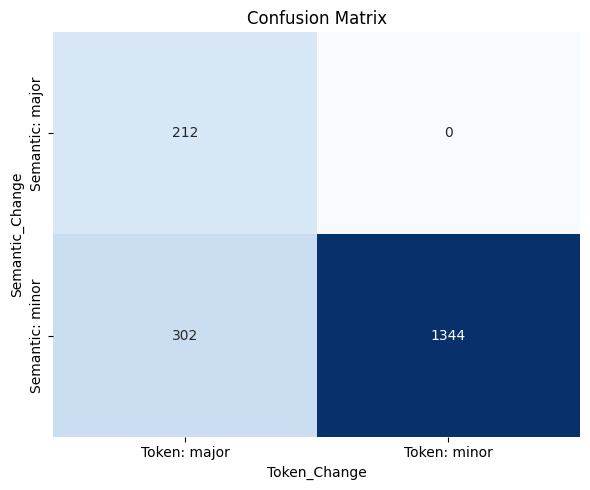

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Read data
df = pd.read_csv("bug_fix_commits_with_change_types.csv")

# Create confusion matrix
cm = confusion_matrix(df["Semantic_Class"], df["Token_Class"], labels=["major", "minor"])

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Semantic: major", "Semantic: minor"],
                        columns=["Token: major", "Token: minor"])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Semantic_Change")
plt.xlabel("Token_Change")
plt.tight_layout()
plt.show()


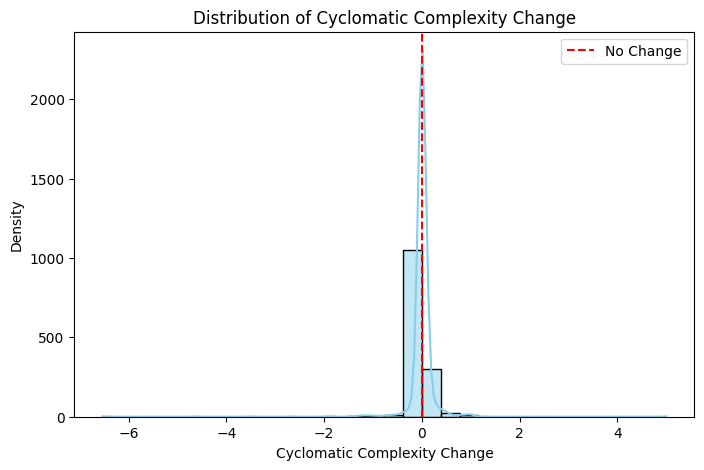

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(df['CC_Change'], bins=30, kde=True, color="skyblue")
plt.axvline(0, color='red', linestyle='--', label='No Change')
plt.xlabel('Cyclomatic Complexity Change')
plt.ylabel('Density')
plt.title('Distribution of Cyclomatic Complexity Change')
plt.legend()
plt.show()


In [24]:
stats = df['LOC_Change'].agg(['mean', 'std', 'min', 'max'])
print(stats)


mean      10.689437
std      117.840291
min     -376.000000
max     3407.000000
Name: LOC_Change, dtype: float64
